In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)


In [7]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)


In [8]:
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

====> Test set loss: 544.4362
====> Epoch: 1 Average loss: 190.0859
====> Test set loss: 136.6447
====> Epoch: 2 Average loss: 132.6675
====> Test set loss: 115.0007
====> Epoch: 3 Average loss: 120.4805
====> Test set loss: 108.7149
====> Epoch: 4 Average loss: 115.6347
====> Test set loss: 104.8940
====> Epoch: 5 Average loss: 113.0278
====> Test set loss: 103.3761
====> Epoch: 6 Average loss: 111.2762
====> Test set loss: 101.1579
====> Epoch: 7 Average loss: 110.0650
====> Test set loss: 100.4145
====> Epoch: 8 Average loss: 109.1494
====> Test set loss: 99.1949
====> Epoch: 9 Average loss: 108.4036
====> Test set loss: 98.0979
====> Epoch: 10 Average loss: 107.7729
====> Test set loss: 99.0075


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


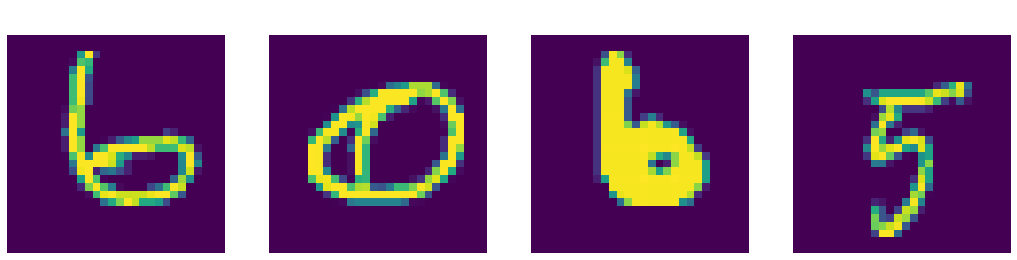

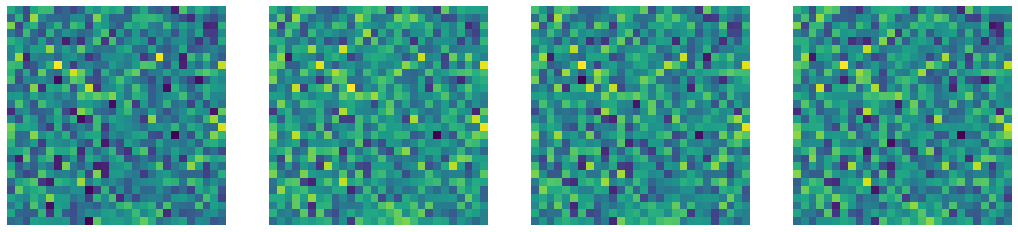

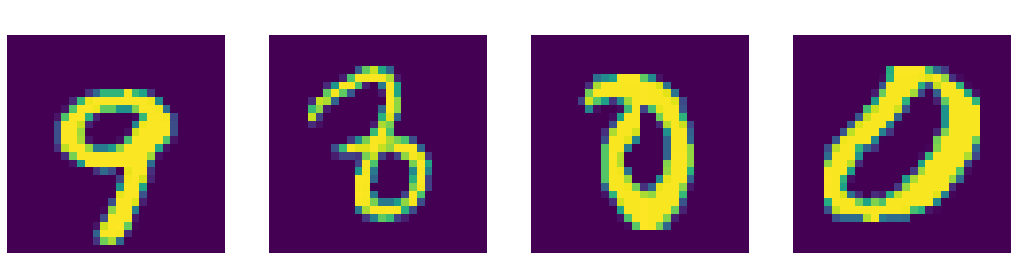

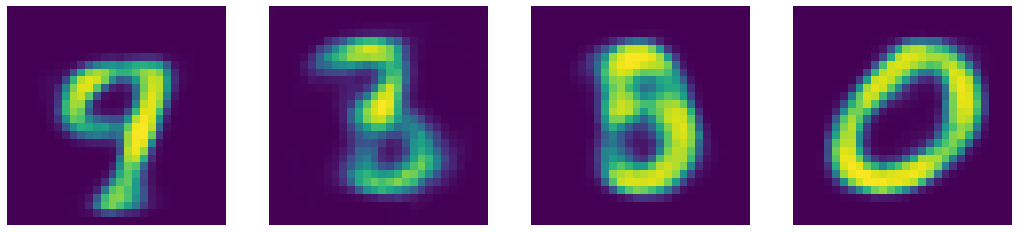

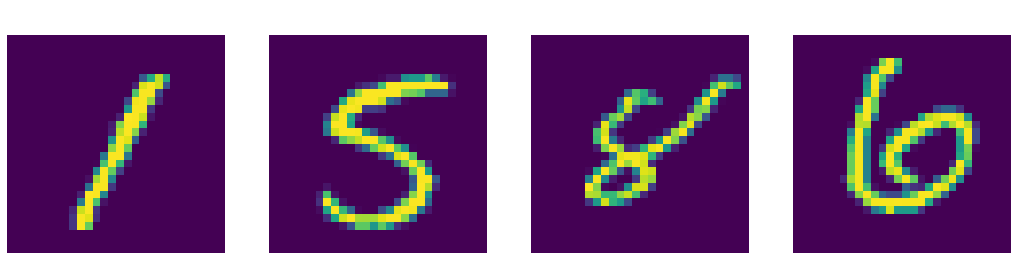

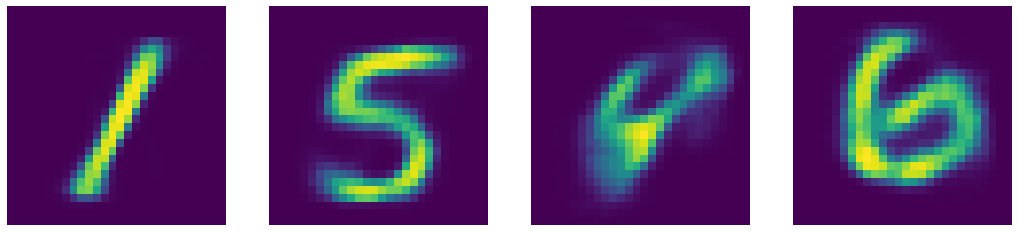

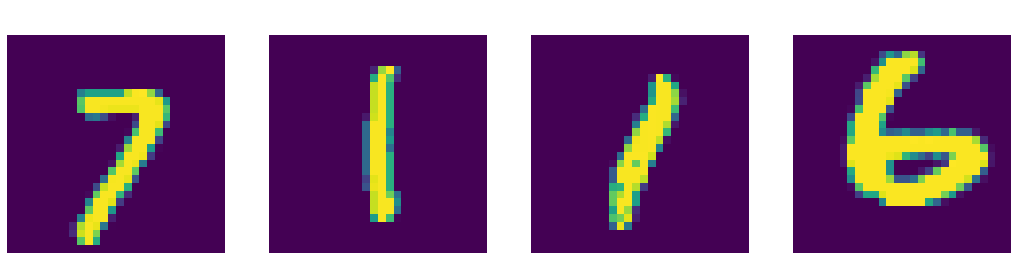

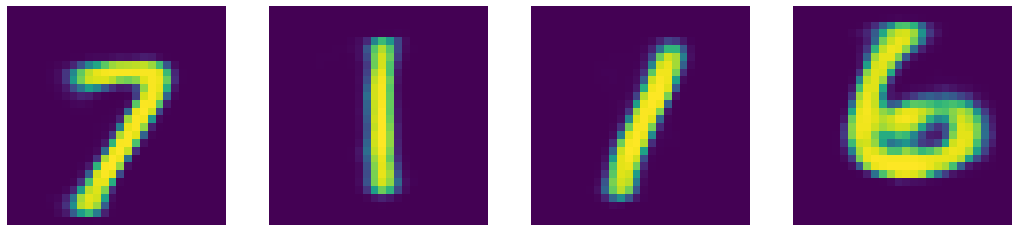

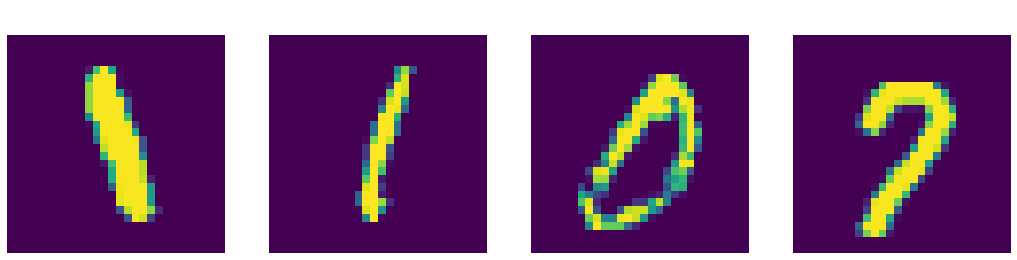

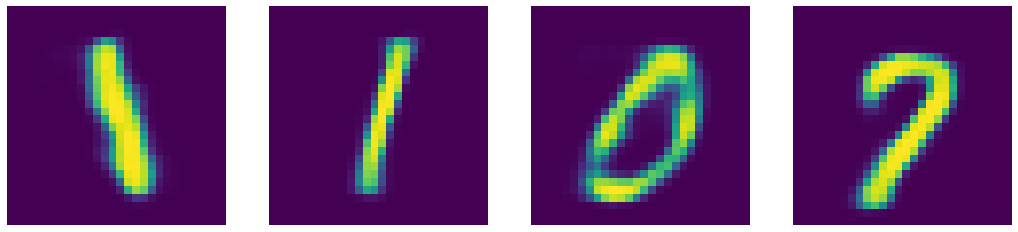

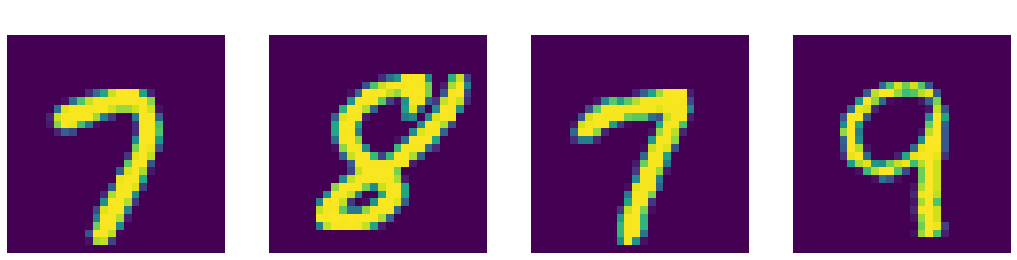

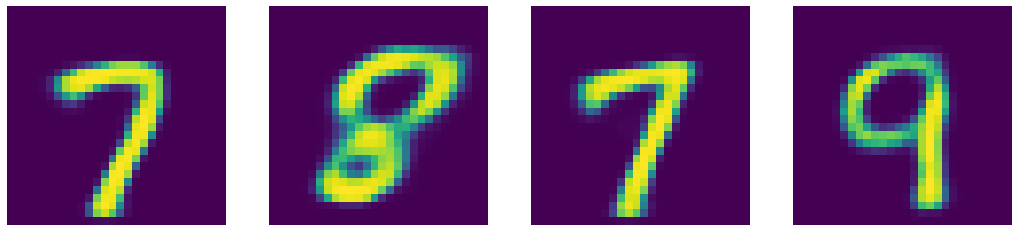

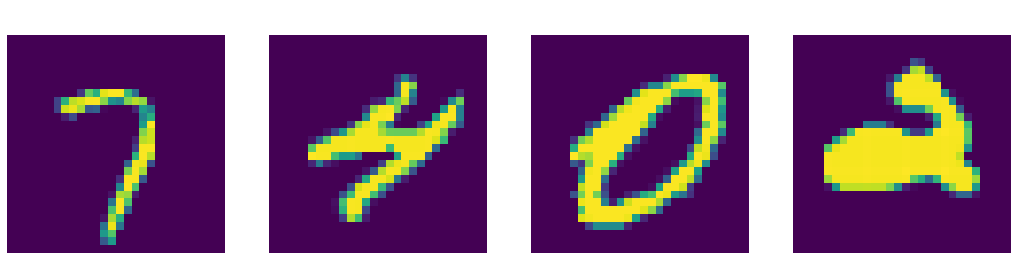

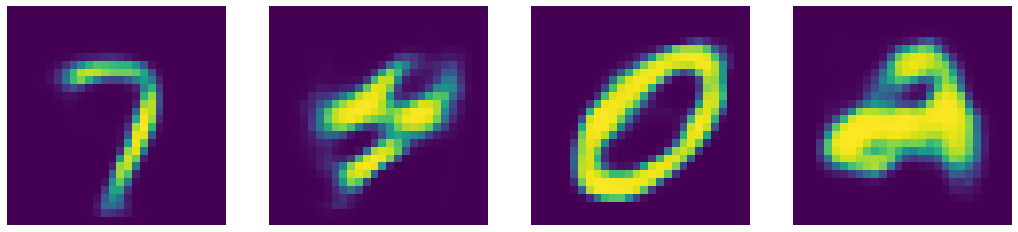

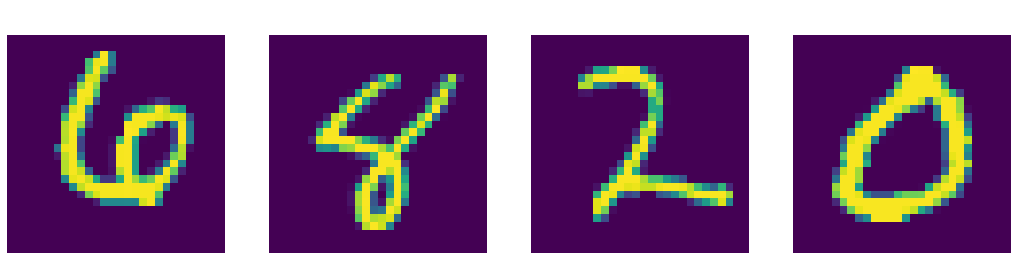

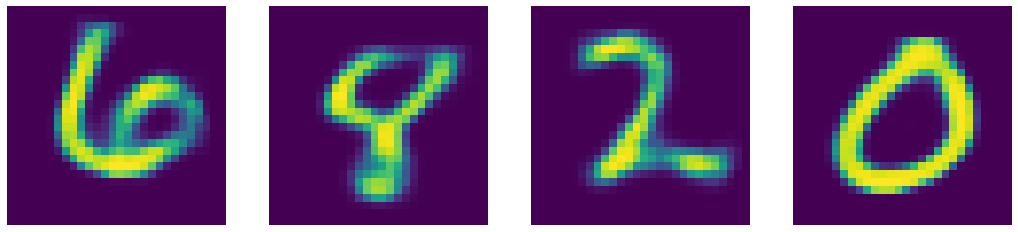

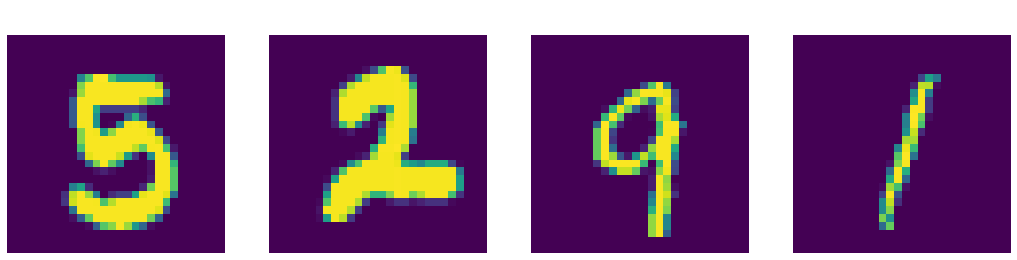

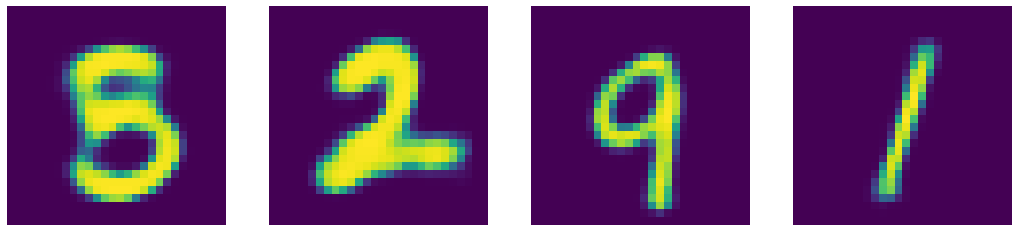

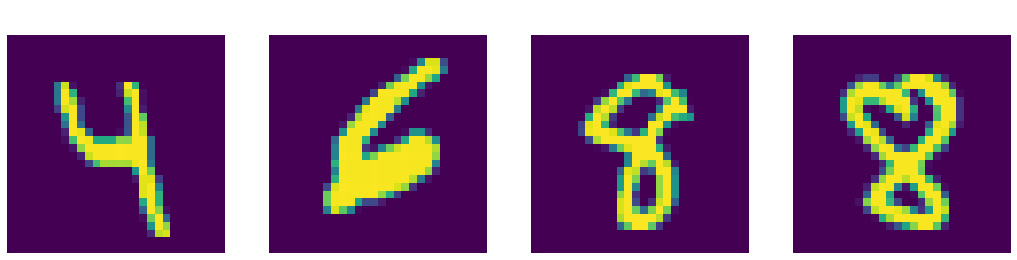

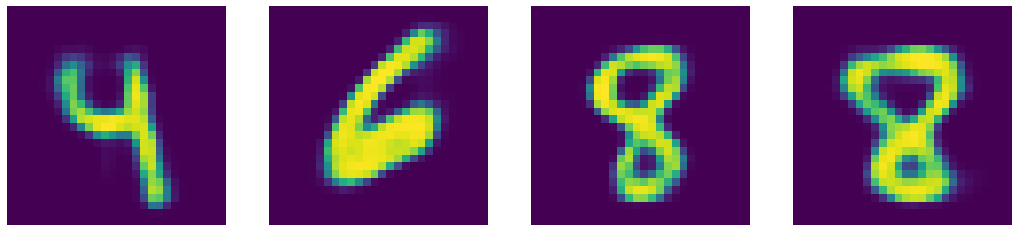

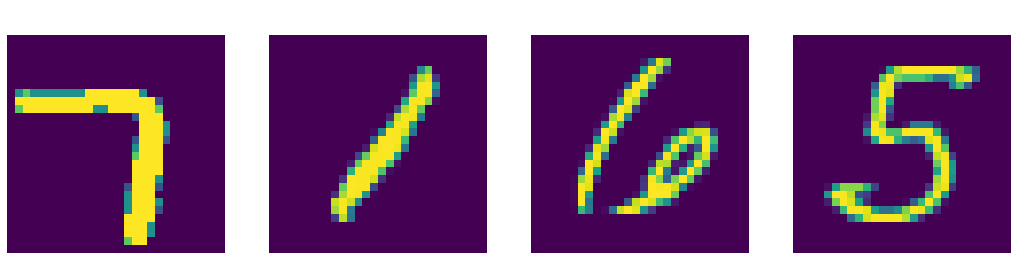

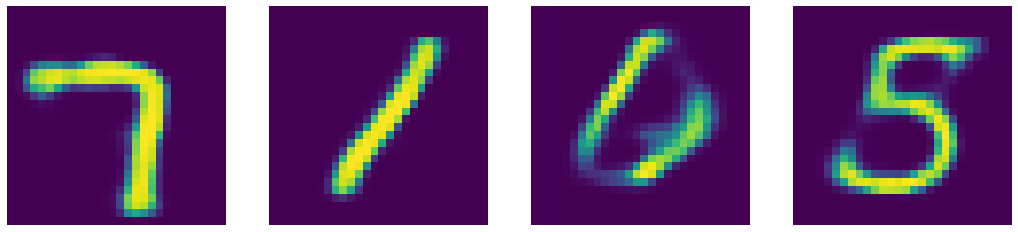

In [9]:
epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

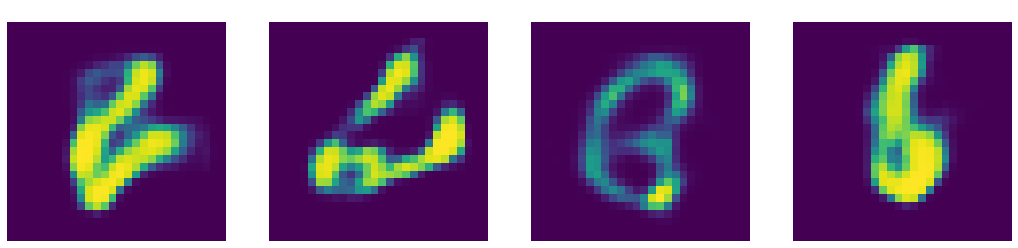

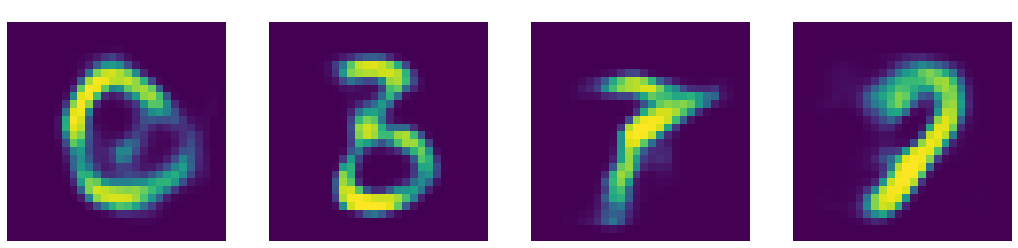

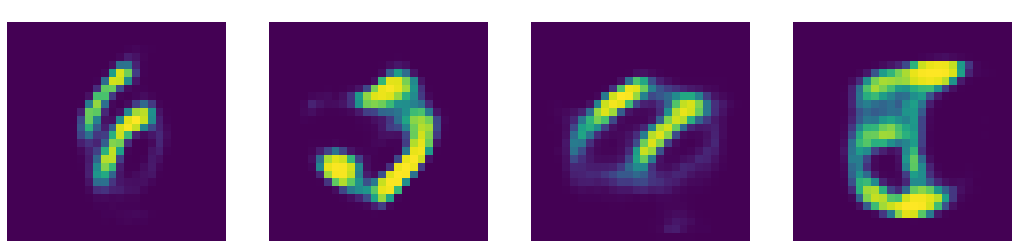

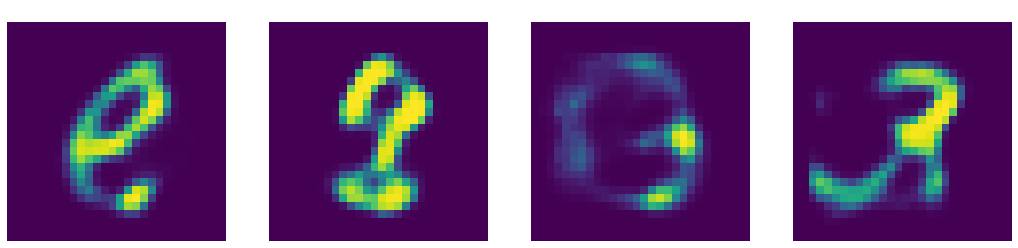

In [11]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

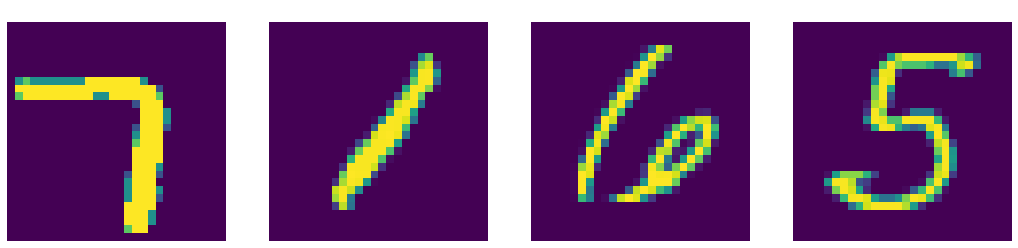

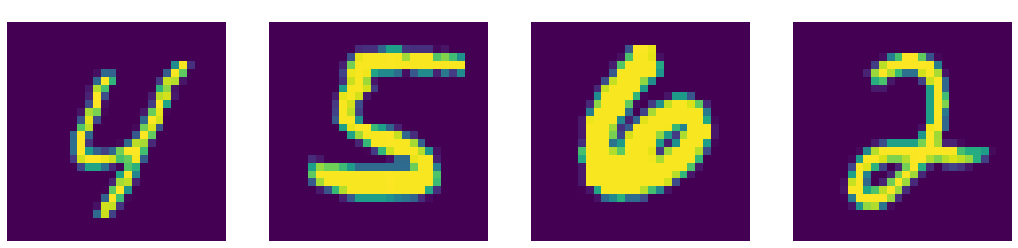

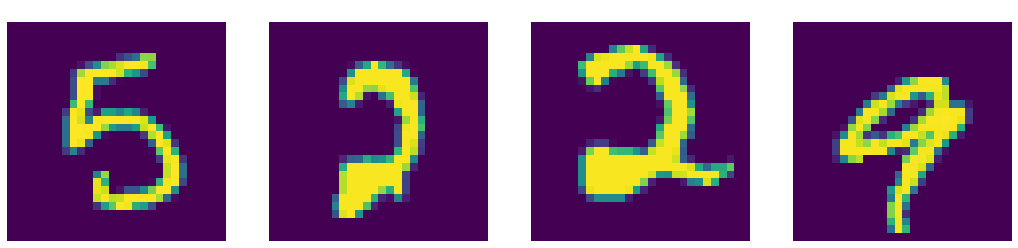

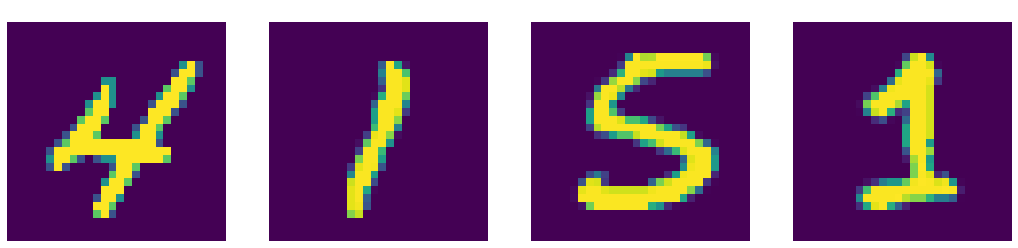

In [12]:
# Display last test batch

display_images(None, x, 4, count=True)

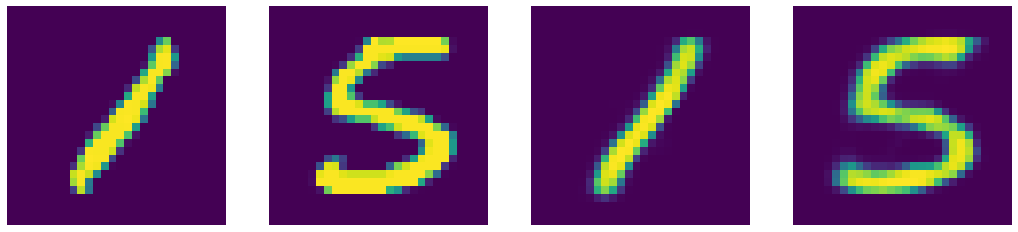

In [13]:
A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

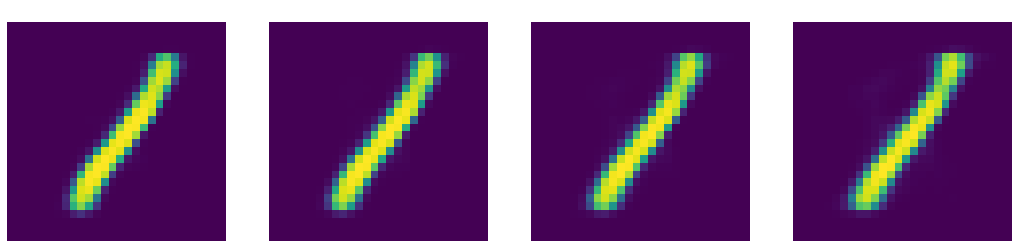

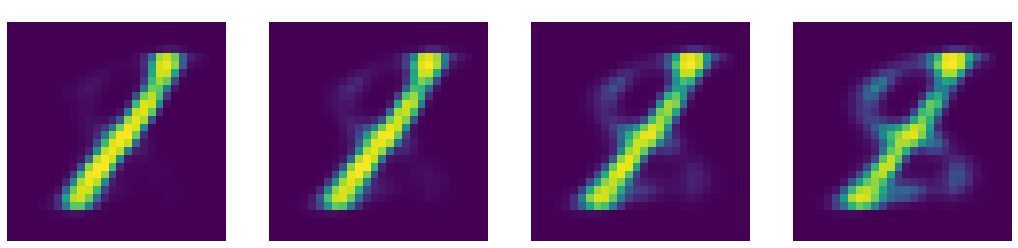

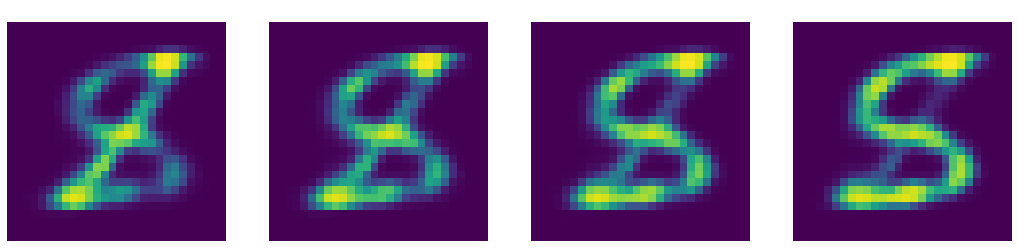

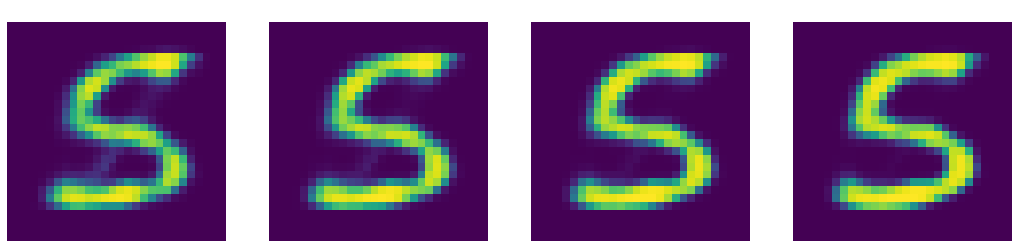

In [14]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [15]:
import numpy as np
from sklearn.manifold import TSNE

In [16]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [17]:
set_default(figsize=(15, 4))

In [19]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].cpu()))
    Y.append(codes['y'][epoch][:N])

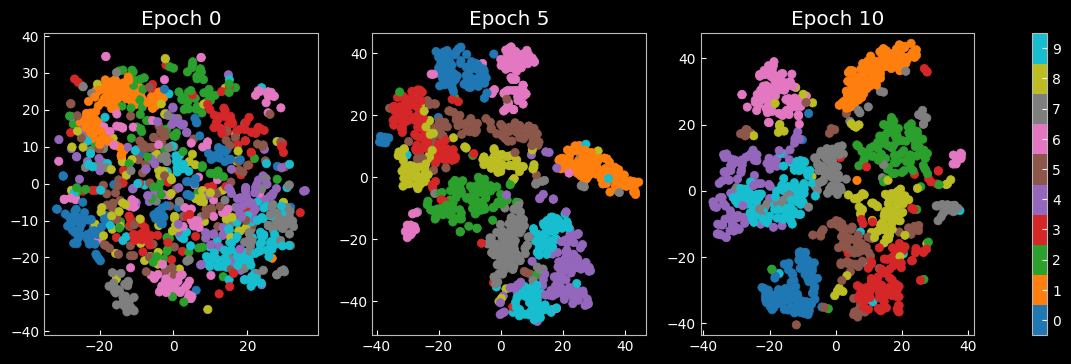

In [20]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

# Test custom dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
ls ../gdrive/MyDrive/Créactif/data/album_covers_small/subfolder

In [ ]:
BATCH_SIZE = 128

In [ ]:
TRAIN_DATA_PATH = "../gdrive/MyDrive/Créactif/data/album_covers_small/"
#TEST_DATA_PATH = "ImageFolder/images/test/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225] )
    ])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data, test_data = torch.utils.data.random_split(dataset, [800, 201])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

In [ ]:
# Defining the model

d = 30

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(128*128*3, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d**2, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 128*128*3),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 128*128*3)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class VAE(nn.Module):
    def __init__(self, zsize, layer_count=3, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

z_size = 512
vae = VAE(zsize=z_size, layer_count=5)
vae.cuda()
vae.train()
vae.weight_init(mean=0, std=0.02)

RuntimeError: ignored

In [ ]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)


In [ ]:
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 128*128*3), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

In [ ]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 3, 128, 128).permute(0,2,3,1)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 3, 128, 128).permute(0,2,3,1)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [ ]:
epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')